# RD-comparison of "Stereo" Transforms

In [227]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import sounddevice as sd
import math

In [228]:
def plot(x, y, xlabel='', ylabel='', title=''):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.grid()
    ax.xaxis.set_label_text(xlabel)
    ax.yaxis.set_label_text(ylabel)
    ax.plot(x, y)
    plt.show(block=False)

## Produce some sound ... for example, say something during 5 s
This sound will be used to compare the RD performance of the transforms.

In [229]:
fs = 44100
duration = 5.0  # seconds
x = sd.rec(int(duration * fs), samplerate=fs, channels=2, dtype=np.int16)
print("Say something!")
while sd.wait():
    pass
print("done")

Say something!
done


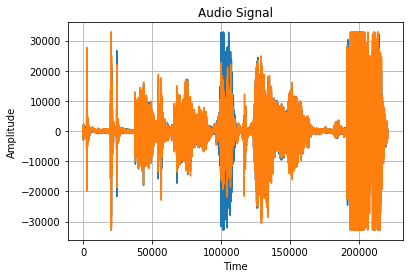

In [230]:
sd.play(x)
plot(np.linspace(0, len(x)-1, len(x)), x, "Time", "Amplitude", "Audio Signal")

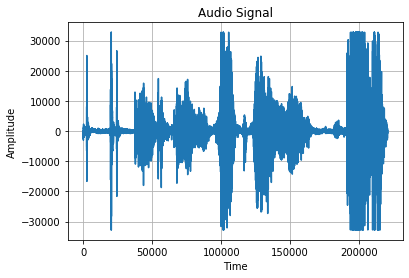

In [231]:
channel_0 = x[:, 0]
sd.play(channel_0)
plot(np.linspace(0, len(channel_0)-1, len(channel_0)), channel_0, "Time", "Amplitude", "Audio Signal")

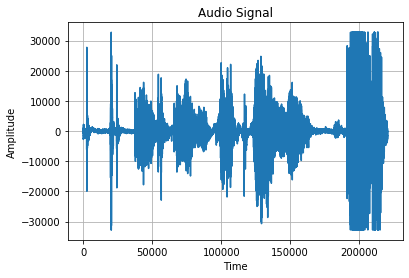

In [232]:
channel_1 = x[:, 1]
sd.play(channel_1)
plot(np.linspace(0, len(channel_1)-1, len(channel_1)), channel_1, "Time", "Amplitude", "Audio Signal")

## RD stuff

In [233]:
def average_energy(x):
    #return np.sum(x[:, 0].astype(np.double)*x[:, 0].astype(np.double))/len(x[:, 0]) + \
    #       np.sum(x[:, 1].astype(np.double)*x[:, 1].astype(np.double))/len(x[:, 1])
    return np.sum(x.astype(np.double)*x.astype(np.double))/len(x)
    
def RMSE(x, y):
    error_signal = x - y
    return math.sqrt(average_energy(error_signal))

# Based on https://stackoverflow.com/questions/15450192/fastest-way-to-compute-entropy-in-python
def entropy_in_bits_per_symbol(sequence_of_symbols):
    value, counts = np.unique(sequence_of_symbols, return_counts = True)
    probs = counts / len(sequence_of_symbols)
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    entropy = 0.
    for i in probs:
        entropy -= i * math.log(i, 2)

    return entropy

def deadzone_quantizer(x, quantization_step):
    k = (x / quantization_step).astype(np.int)
    return k

def deadzone_dequantizer(k, quantization_step):
    y = quantization_step * k
    return y

def deadzone_qdeq(x, quantization_step):
    k = deadzone_quantizer(x, quantization_step)
    y = deadzone_dequantizer(k, quantization_step)
    return k, y

def RD_curve(chunk, analyze, synthesize):
    RD_points = []
    for q_step in range(16, 1024, 32):
        analyzed_chunk = analyze(chunk)
        k, y = deadzone_qdeq(analyzed_chunk, q_step)
        rate = entropy_in_bits_per_symbol(k[:, 0]) + entropy_in_bits_per_symbol(k[:, 1])
        reconstructed_chunk = synthesize(y)
        distortion = RMSE(chunk, reconstructed_chunk)
        RD_points.append((rate, distortion))
    return RD_points

## [Karhunen-Loéve Transform (KLT)](https://en.wikipedia.org/wiki/Karhunen%E2%80%93Lo%C3%A8ve_theorem), [Hadamard](https://en.wikipedia.org/wiki/Hadamard_transform) and [Haar](https://en.wikipedia.org/wiki/Haar_wavelet#Haar_matrix)

The rows (i.e., the [basis](https://en.wikipedia.org/wiki/Basis_(linear_algebra)) vectors) of the of the [discrete](https://en.wikipedia.org/wiki/Discrete_transform) (all transforms discussed in this document are discrete) KLT consist of the [eigenvectors](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors#:~:text=In%20linear%20algebra%2C%20an%20eigenvector,which%20the%20eigenvector%20is%20scaled.) of the [autorrelation matrix](https://en.wikipedia.org/wiki/Autocorrelation#Auto-correlation_of_random_vectors) (also known as the [covariance](https://en.wikipedia.org/wiki/Covariance) matrix) of the transformed signal. It can be assumed that, on average, the amount of information provided by a subband (the set of coefficients that correspond to a given frequency in block-based transform coding) is proportional to the variance in this subband.

The KLT minize the [geometric mean](https://en.wikipedia.org/wiki/Geometric_mean) of the variance of the transform coefficients. Hence, the KLT provides optimum energy concentration and therefore, the largest [transformation coding gain (TG)](/http://ws2.binghamton.edu/fowler/fowler%20personal%20page/EE523_files/Ch_13_3%20Transform%20Coding%20-%20Coding%20Gain%20&%20Classic%20Transforms%20(PPT).pdf) of any linear transform coding method. Unfortunately, the autocorrelation matrix depends on the transformed signal and therefore, the [change of basis](https://en.wikipedia.org/wiki/Change_of_basis) (the transform) provided by the KLT is signal dependent (each signal needs to be transformed by a different transform matrix), except in the case of 2-samples [block coding](https://web.stanford.edu/class/ee368b/Handouts/11-TransformCoding.pdf).

The TG is defined as the ratio of the arithmetic mean of the variances of the coefficients to their geometric means:

\begin{equation}
G_{TC} = \frac{\frac{1}{N}\sum_{i=1}^N{\sigma_i^2}}{(\prod_{i=1}^N\sigma_i^2)^{\frac{1}{N}}}
\end{equation}

In [234]:
def TCG(variances):
    N = len(variances)
    arithmetic_mean = np.sum(variances)/N
    geometric_mean = np.prod(variances)**(1/N)
    if geometric_mean == 0:
        geometric_mean = 1
    transform_coding_gain = arithmetic_mean/geometric_mean
    return transform_coding_gain

In [235]:
# Forward transform:
#
#  [w[0]] = 1/sqrt(2) [1  1] [x[0]]
#  [w[1]]             [1 -1] [x[1]]
def KLT_analyze(x):
    w = np.empty_like(x, dtype=np.int32)
    w[:, 0] = np.rint((x[:, 0].astype(np.int32) + x[:, 1]) / math.sqrt(2)) # L
    w[:, 1] = np.rint((x[:, 0].astype(np.int32) - x[:, 1]) / math.sqrt(2)) # H
    return w

# Inverse transform:
#
#  [x[0]] = 1/sqrt(2) [1  1] [w[0]]
#  [x[1]]             [1 -1] [w[1]]
def KLT_synthesize(w):
    x = np.empty_like(w, dtype=np.int16)
    #x[:, 0] = np.rint((w[:, 0] + w[:, 1]) / math.sqrt(2)) # L(ow frequency subband)
    #x[:, 1] = np.rint((w[:, 0] - w[:, 1]) / math.sqrt(2)) # H(igh frequency subband)
    x[:, :] = KLT_analyze(w)
    return x

## [Mid/Side stereo Coding (MSC)](https://en.wikipedia.org/wiki/Joint_encoding#M/S_stereo_coding)

MSC transforms the left and right channels into a mid channel and a side channel. The mid channel is the sum of the left and right channels, or $M=L+R$. The side channel is the difference of the left and right channels, or $S=L-R$. See also Section 2.2.1. *Sum-Difference coding* at this [PhD thesis](https://research.tue.nl/en/studentTheses/stereo-coding-by-two-channel-linear-prediction-and-rotation).

The main advantage of MSC over KLT is the use only of integer arithmetic in MSC, which allows faster implementations.

In [236]:
# Forward transform:
#
#  [w[0]] = [1  1] [x[0]]
#  [w[1]]   [1 -1] [x[1]]

def MSC_analyze(x):
    w = np.empty_like(x, dtype=np.int32)
    w[:, 0] = x[:, 0].astype(np.int32) + x[:, 1] # L(ow frequency subband)
    w[:, 1] = x[:, 0].astype(np.int32) - x[:, 1] # H(igh frequency subband)
    return w

# Inverse transform:
#
#  [x[0]] = 1/2 [1  1] [w[0]]
#  [x[1]]       [1 -1] [w[1]]

def MSC_synthesize(w):
    x = np.empty_like(w, dtype=np.int16)
    x[:, 0] = (w[:, 0] + w[:, 1])/2 # L(ow frequency subband)
    x[:, 1] = (w[:, 0] - w[:, 1])/2 # H(igh frequency subband)
    return x

# This solution is slower than the previous one because: (1) an array of int32 is allocated,
# and (2) the memory locality is smaller (the division by 2 is not performed just when
# the samples are accesed).
def _MSC_synthesize(w):
    x = np.empty_like(w, dtype=np.int16)
    x[:, :] = MSC_analyze(w)
    x = x / 2
    return x

In [237]:
w = MSC_analyze(x)

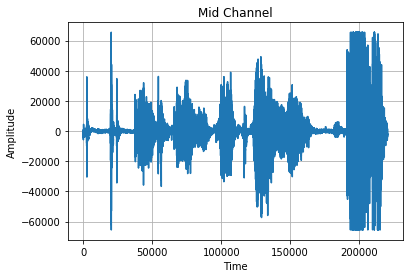

In [238]:
plot(np.linspace(0, len(x)-1, len(x)), w[:, 0], "Time", "Amplitude", "Mid Channel")
sd.play(w[:, 0].astype(np.int16))

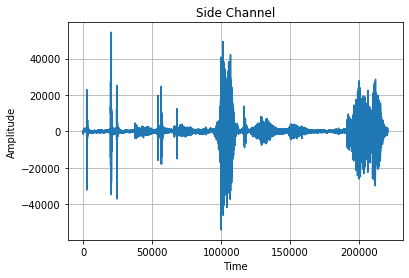

In [239]:
plot(np.linspace(0, len(x)-1, len(x)), w[:, 1], "Time", "Amplitude", "Side Channel")
sd.play(w[:, 1].astype(np.int16))

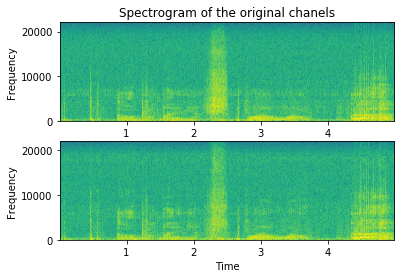

In [240]:
plt.subplot(211)
plt.title('Spectrogram of the original chanels')
plt.specgram(x[:, 0], Fs=44100)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.subplot(212)
plt.specgram(x[:, 1],Fs=44100)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

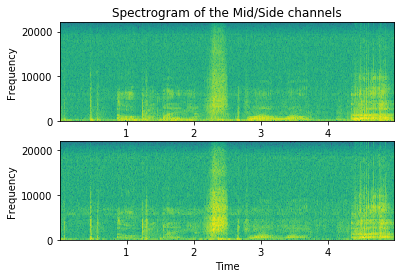

In [241]:
plt.subplot(211)
plt.title('Spectrogram of the Mid/Side channels')
plt.specgram(w[:, 0], Fs=44100)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.subplot(212)
plt.specgram(w[:, 1], Fs=44100)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

<ipython-input-242-7fc47846f5d6>:13: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w2, 20 * np.log10(abs(h2)), 'b')


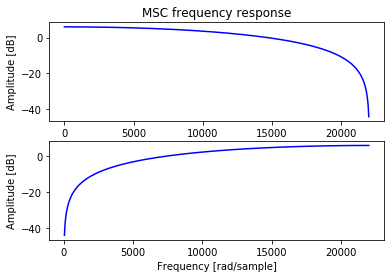

In [242]:
from scipy import signal
K1 = np.array([1.0, 1.0])
w1, h1 = signal.freqz(K1, fs=44100)
K2 = np.array([1.0, -1.0])
w2, h2 = signal.freqz(K2, fs=44100)

plt.subplot(211)
plt.title('MSC frequency response')
plt.plot(w1, 20 * np.log10(abs(h1)), 'b')
plt.xlabel('Frequency [rad/sample]')
plt.ylabel('Amplitude [dB]')
plt.subplot(212)
plt.plot(w2, 20 * np.log10(abs(h2)), 'b')
plt.xlabel('Frequency [rad/sample]')
plt.ylabel('Amplitude [dB]')
plt.show()

## MSC vs KLT

In [243]:
MSC_RD_points = RD_curve(x, MSC_analyze, MSC_synthesize)

In [244]:
KLT_RD_points = RD_curve(x, KLT_analyze, KLT_synthesize)

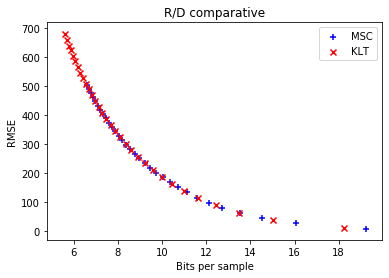

In [245]:
plt.title("R/D comparative")
plt.xlabel("Bits per sample")
plt.ylabel("RMSE")
#plt.xscale("log")
#plt.yscale("log")
plt.scatter(*zip(*MSC_RD_points), c='b', marker="+", label='MSC')
plt.scatter(*zip(*KLT_RD_points), c='r', marker="x", label='KLT')
plt.legend(loc='upper right')
plt.show()

In [246]:
%timeit MSC_synthesize(MSC_analyze(x))

1.7 ms ± 63.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [247]:
%timeit KLT_synthesize(KLT_analyze(x))

4.78 ms ± 65.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


As it can be seen, MSC and KLT are equivalent from a R/D perspective. However,  MSC is faster.

In [248]:
LH = MSC_analyze(x)
L = LH[:, 0]
H = LH[:, 1]
variances = [None]*2
variances[0] = np.var(L)
variances[1] = np.var(H)
print(TCG(variances))

1.8289124449766783


In [249]:
LH = KLT_analyze(x)
L = LH[:, 0]
H = LH[:, 1]
variances = [None]*2
variances[0] = np.var(L)
variances[1] = np.var(H)
print(TCG(variances))

1.828912855133498


The TCG of the KLT is sliiiightly better than the TCG of the MSC.

## S Transform (ST)
In-place?

In [250]:
# https://www.researchgate.net/profile/Amir_Said2/publication/2598141_Reversible_Image_Compression_Via_Multiresolution_Representation_and_Predictive_Coding/links/56952cf008ae820ff074a536/Reversible-Image-Compression-Via-Multiresolution-Representation-and-Predictive-Coding.pdf
#
# Forward transform:
#
#  w[0] = ceil((x[0] + x[1])/2)
#  w[1] = x[0] - x[1] 
#
# Inverse transform:
#
#  x[0] = w[0] + ceil((w[1]+1)/2)
#  x[1] = x[0] - w[1]

def ST_analyze(x):
    w = np.empty_like(x, dtype=np.int32)
    w[:, 0] = np.ceil((x[:, 0].astype(np.int32) + x[:, 1])/2)
    w[:, 1] = x[:, 0].astype(np.int32) - x[:, 1]
    return w

def ST_synthesize(w):
    x = np.empty_like(w, dtype=np.int16)
    x[:, 0] = w[:, 0] + np.ceil((w[:, 1] + 1)/2)
    x[:, 1] = x[:, 0] - w[:, 1]
    return x

## ST vs MSC

In [251]:
ST_RD_points = RD_curve(x, ST_analyze, ST_synthesize)

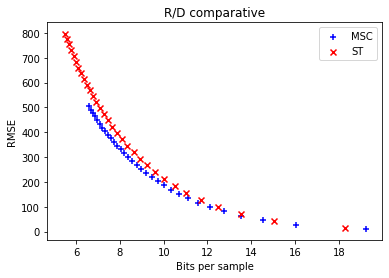

In [252]:
plt.title("R/D comparative")
plt.xlabel("Bits per sample")
plt.ylabel("RMSE")
#plt.xscale("log")
#plt.yscale("log")
plt.scatter(*zip(*MSC_RD_points), c='b', marker="+", label='MSC')
plt.scatter(*zip(*ST_RD_points), c='r', marker="x", label='ST')
plt.legend(loc='upper right')
plt.show()

MSC performs slighly better than ST.

In [253]:
import zlib

def stereo_DEFLATE_RD_curve(chunk, analyze, synthesize):
    RD_points = []
    for q_step in range(16, 1024, 32):
        analyzed_chunk = analyze(chunk)
        k, y = deadzone_qdeq(analyzed_chunk, q_step)
        subband_0 = k[:, 0].copy()
        subband_1 = k[:, 1].copy()
        rate = len(zlib.compress(subband_0)) + len(zlib.compress(subband_1))
        #rate = entropy_in_bits_per_symbol(k[:, 0]) + entropy_in_bits_per_symbol(k[:, 1])
        reconstructed_chunk = synthesize(y)
        distortion = RMSE(chunk, reconstructed_chunk)
        RD_points.append((rate, distortion))
    return RD_points

def _stereo_DEFLATE_RD_curve(chunk, analyze, synthesize):
    ch0_RD_points = []
    ch1_RD_points = []
    for q_step in range(16, 1024, 32):
        analyzed_chunk = analyze(chunk)
        k, y = deadzone_qdeq(analyzed_chunk, q_step)
        tmp = y.copy()
        y[:, 1] = 0
        
        reconstructed_chunk_with_subband_0 = synthesize(y)
        distortion_only_subband_0 = RMSE(chunk, reconstructed_chunk_with_subband_0)
        rate_subband_0 = len(zlib.compress(k[:, 0].copy()))
        ch0_RD_points.append((rate_subband_0, distortion_only_subband_0))
        
        y = tmp.copy()
        y[:, 0] = 0
        #y[:, 1] = 0
        reconstructed_chunk_with_subband_1 = synthesize(y)
        distortion_only_subband_1 = RMSE(chunk, reconstructed_chunk_with_subband_1)
        rate_subband_1 = len(zlib.compress(k[:, 1].copy()))
        ch1_RD_points.append((rate_subband_1, distortion_only_subband_1))
    return [ch0_RD_points, ch1_RD_points]

In [254]:
MSC_RD_points = DEFLATE_RD_curve(x, MSC_analyze, MSC_synthesize)

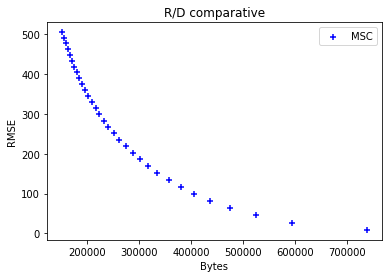

In [255]:
plt.title("R/D comparative")
plt.xlabel("Bytes")
plt.ylabel("RMSE")
#plt.xscale("log")
#plt.yscale("log")
plt.scatter(*zip(*MSC_RD_points), c='b', marker="+", label='MSC')
#plt.scatter(*zip(*KLT_RD_points), c='r', marker="x", label='KLT')
plt.legend(loc='upper right')
plt.show()

In [256]:
MSC_RD_points = _stereo_DEFLATE_RD_curve(x, MSC_analyze, MSC_synthesize)

In [257]:
print(MSC_RD_points[1])

[(338538, 8117.542368826672), (263314, 8117.562449792218), (229505, 8117.602466710629), (205269, 8117.661505841973), (187194, 8117.738673657021), (172069, 8117.834627111143), (160636, 8117.945942937941), (149741, 8118.073927997102), (138905, 8118.213388562804), (130226, 8118.374778942775), (123088, 8118.546622789863), (116605, 8118.730773560053), (109868, 8118.925694670059), (104294, 8119.1251973268945), (99090, 8119.345486288552), (93966, 8119.56310687866), (89966, 8119.796626816566), (86216, 8120.031533467585), (82716, 8120.279861398163), (79420, 8120.536396023811), (76621, 8120.784946925583), (74058, 8121.038904513189), (71458, 8121.317100915564), (68966, 8121.604602812568), (66540, 8121.865020403306), (64574, 8122.127100464494), (62848, 8122.408656155905), (61064, 8122.715071345761), (59473, 8123.028447713222), (57885, 8123.336425115605), (56349, 8123.64700811821), (55011, 8123.949866960584)]


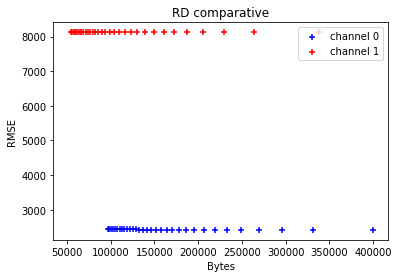

In [258]:
plt.title("RD comparative")
plt.xlabel("Bytes")
plt.ylabel("RMSE")
#plt.xscale("log")
#plt.yscale("log")
plt.scatter(*zip(*MSC_RD_points[0]), c='b', marker="+", label='channel 0')
plt.scatter(*zip(*MSC_RD_points[1]), c='r', marker="+", label='channel 1')
#plt.scatter(*zip(*KLT_RD_points), c='r', marker="x", label='KLT')
plt.legend(loc='upper right')
plt.show()

In [ ]:
plt.subplot(121)
plt.scatter(*zip(*MSC_RD_points[0]), c='b', marker="+", label='channel 0')
plt.title('Mid Channel')
plt.xlabel('Bytes')
plt.ylabel('RMSE')
#plt.xlim(0, 400000)
plt.subplot(122)
plt.scatter(*zip(*MSC_RD_points[1]), c='r', marker="+", label='channel 1')
plt.title('Side Channel')
plt.xlabel('Bytes')
#plt.xlim(0, 400000)
#plt.ylabel('RMSE')
plt.show()

# ========================

## MSC/2

In [619]:
# Forward transform:
#
#  [w[0]] = 1/2 [1  1] [x[0]]
#  [w[1]]       [1 -1] [x[1]]
#
# Inverse transform:
#
#  [x[0]] = [1  1] [w[0]]
#  [x[1]]   [1 -1] [w[1]]

def _MSC2_analyze(x):
    w = np.empty_like(x, dtype=np.int32)
    w[:, 0] = (x[:, 0].astype(np.int32) + x[:, 1])/2 # L(ow frequency subband)
    w[:, 1] = (x[:, 0].astype(np.int32) - x[:, 1])/2 # H(igh frequency subband)
    #w[:, 0] = w[:, 0] / 2
    return w

def MSC2_analyze(x):
    w = np.empty_like(x, dtype=np.int32)
    w[:, 0] = (x[:, 0].astype(np.int32) + x[:, 1])/2 # L(ow frequency subband)
    w[:, 1] = (x[:, 0].astype(np.int32) - x[:, 1])/2 # H(igh frequency subband)
    #w[:, 0] = w[:, 0] / 2
    return w

def _MSC2_synthesize(w):
    x = np.empty_like(w, dtype=np.int16)
    #w[:, 0] = w[:, 0] * 2
    x[:, :] = MSC2_analyze(w)
    return x

def MSC2_synthesize(w):
    x = np.empty_like(w, dtype=np.int16)
    x[:, 0] = w[:, 1] + x[:, 1]
    x[:, 1] = w[:, 0] - x[:, 0]
    #w[:, 0] = w[:, 0] * 2
    #x[:, :] = MSC2_analyze(w)
    return x

## MSC vs MSC2

In [620]:
MSC2_RD_points = RD_curve(x, MSC2_analyze, MSC2_synthesize)

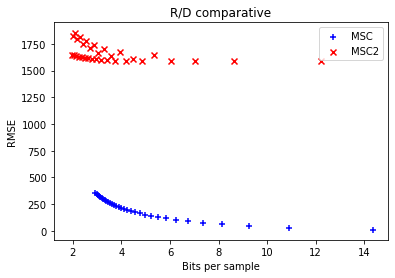

In [621]:
plt.title("R/D comparative")
plt.xlabel("Bits per sample")
plt.ylabel("RMSE")
#plt.xscale("log")
#plt.yscale("log")
plt.scatter(*zip(*MSC_RD_points), c='b', marker="+", label='MSC')
plt.scatter(*zip(*MSC2_RD_points), c='r', marker="x", label='MSC2')
plt.legend(loc='upper right')
plt.show()

In [608]:
%timeit MSC2_synthesize(MSC2_analyze(x))

3.34 ms ± 437 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## ?? transform

In [561]:
# Forward transform:
#
#  [w[0]] = 1/2 [1  1] [x[0]]
#  [w[1]]       [1 -1] [x[1]]
#
# Inverse transform:
#
#  [x[0]] = [1  1] [w[0]]
#  [x[1]]   [1 -1] [w[1]]
#
# Forward transform:
#
#  w[1] = x[0] - x[1] 
#  w[0] = x[0] - w[1]/2
#  w[1] /= 2
#
# Inverse transform:
#
#  w[1] *= 2
#  x[0] = w[0] + w[1]/2
#  x[1] = x[0] - w[1]

def orig2_analyze(x):
    w = np.empty_like(x, dtype=np.int32)
    w[:, 1] = x[:, 0].astype(np.int32) - x[:, 1]
    w[:, 0] = x[:, 0] - w[:, 1] / 2
    w[:, 1] = w[:, 1] / 2
    return w

def orig2_synthesize(w):
    x = np.empty_like(w, dtype=np.int16)
    w[:, 1] = w[:, 1] * 2
    x[:, 0] = w[:, 0] + w[:, 1]/2
    x[:, 1] = x[:, 0] - w[:, 1]
    return x

In [562]:
orig2_RD_points = RD_curve(x, orig2_analyze, orig2_synthesize)

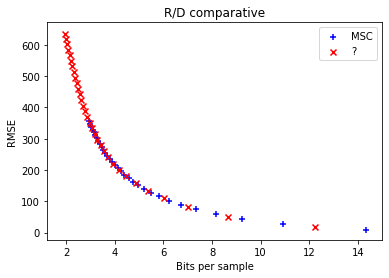

In [563]:
plt.title("R/D comparative")
plt.xlabel("Bits per sample")
plt.ylabel("RMSE")
#plt.xscale("log")
#plt.yscale("log")
plt.scatter(*zip(*MSC_RD_points), c='b', marker="+", label='MSC')
plt.scatter(*zip(*orig2_RD_points), c='r', marker="x", label='?')
plt.legend(loc='upper right')
plt.show()

In [564]:
%timeit orig2_synthesize(orig2_analyze(x))

5.42 ms ± 71.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## ? transform

In [412]:
# Forward transform:
#
#  w[1] = x[1] - x[0] 
#  w[0] = x[0] + w[1]/2
#  w[1] /= 2
#
# Inverse transform:
#
#  w[1] *= 2
#  x[0] = w[0] - w[1]/2
#  x[1] = x[0] + w[1]

def orig_analyze(x):
    w = np.empty_like(x, dtype=np.int32)
    w[:, 1] = x[:, 1].astype(np.int32) - x[:, 0]
    w[:, 0] = x[:, 0] + np.rint(w[:, 1] / 2)
    w[:, 1] = np.rint(w[:, 1] / 2)
    return w

def orig_synthesize(w):
    x = np.empty_like(w, dtype=np.int16)
    w[:, 1] = w[:, 1] * 2
    x[:, 0] = w[:, 0] - np.rint(w[:, 1]/2)
    x[:, 1] = w[:, 1] + x[:, 0]
    return x

In [413]:
orig_RD_points = RD_curve(x, orig_analyze, orig_synthesize)

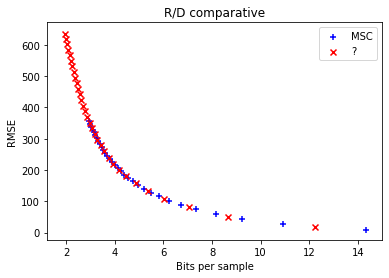

In [414]:
plt.title("R/D comparative")
plt.xlabel("Bits per sample")
plt.ylabel("RMSE")
#plt.xscale("log")
#plt.yscale("log")
plt.scatter(*zip(*MSC_RD_points), c='b', marker="+", label='MSC')
plt.scatter(*zip(*orig_RD_points), c='r', marker="x", label='?')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Introduction to Data Compression (Sayood), pag. 402

def pordeterminar_analyze(chunk):
    analyzed_chunk = np.empty_like(chunk, dtype=np.int16)
    analyzed_chunk[:, 1] = chunk[:, 1] - chunk[:, 0]
    analyzed_chunk[:, 0] = chunk[:, 0] + np.rint(analyzed_chunk[:, 1]/2)
    return analyzed_chunk

def pordeterminar_synthesize(analyzed_chunk):
    chunk = np.empty_like(analyzed_chunk, dtype=np.int16)
    chunk[:, 0] = analyzed_chunk[:, 0] - np.rint(analyzed_chunk[:, 1]/2)
    chunk[:, 1] = analyzed_chunk[:, 1] + chunk[:, 0]
    return chunk

In [137]:
def orig2_analyze(chunk):
    analyzed_chunk = np.empty_like(chunk, dtype=np.int16)
    analyzed_chunk[:, 1] = chunk[:, 1] - chunk[:, 0]
    analyzed_chunk[:, 0] = (chunk[:, 0] + chunk[:, 1]) // 2
    return analyzed_chunk

def orig2_synthesize(analyzed_chunk):
    chunk = np.empty_like(analyzed_chunk, dtype=np.int16)
    chunk[:, 1] = analyzed_chunk[:, 0] + analyzed_chunk[:, 1] // 2
    chunk[:, 0] = chunk[:, 1] - analyzed_chunk[:, 1]
    return chunk

In [142]:
def orig3_analyze(chunk):
    analyzed_chunk = np.empty_like(chunk, dtype=np.int16)
    analyzed_chunk[:, 1] = chunk[:, 1] - chunk[:, 0]
    analyzed_chunk[:, 0] = chunk[:, 0] + np.rint(analyzed_chunk[:, 1]/2)
    analyzed_chunk[:, 1] = analyzed_chunk[:, 1] // 2
    return analyzed_chunk

def orig3_synthesize(analyzed_chunk):
    chunk = np.empty_like(analyzed_chunk, dtype=np.int16)
    analyzed_chunk[:, 1] = analyzed_chunk[:, 1] * 2
    chunk[:, 0] = analyzed_chunk[:, 0] - np.rint(analyzed_chunk[:, 1]/2)
    chunk[:, 1] = analyzed_chunk[:, 1] + chunk[:, 0]
    return chunk

In [225]:
orig_RD_points = RD_curve(x, orig_analyze, orig_synthesize)

In [226]:
orig2_RD_points = RD_curve(x, orig2_analyze, orig2_synthesize)

In [227]:
orig3_RD_points = RD_curve(x, orig3_analyze, orig3_synthesize)

In [231]:
pd_RD_points = RD_curve(x, pordeterminar_analyze, pordeterminar_synthesize)

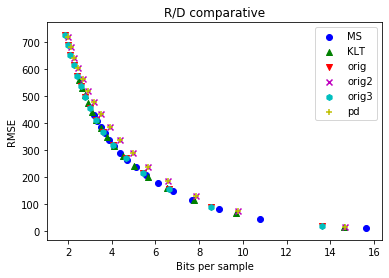

In [235]:
plt.title("R/D comparative")
plt.xlabel("Bits per sample")
plt.ylabel("RMSE")
#plt.xscale("log")
#plt.yscale("log")
plt.scatter(*zip(*MS_RD_points), c='b', marker="o", label='MS')
plt.scatter(*zip(*KLT_RD_points), c='g', marker="^", label='KLT')
plt.scatter(*zip(*orig_RD_points), c='r', marker="v", label='orig')
plt.scatter(*zip(*orig2_RD_points), c='m', marker="x", label='orig2')
plt.scatter(*zip(*orig3_RD_points), c='c', marker="h", label='orig3')
plt.scatter(*zip(*pd_RD_points), c='y', marker="+", label='pd')
plt.legend(loc='upper right')
plt.show()